Dataset shape: (2191, 4)

Missing values:
 subject    0
body       0
date       0
from       0
dtype: int64

Sentiment Distribution:
sentiment
Neutral     1056
Positive     971
Negative     164
Name: count, dtype: int64


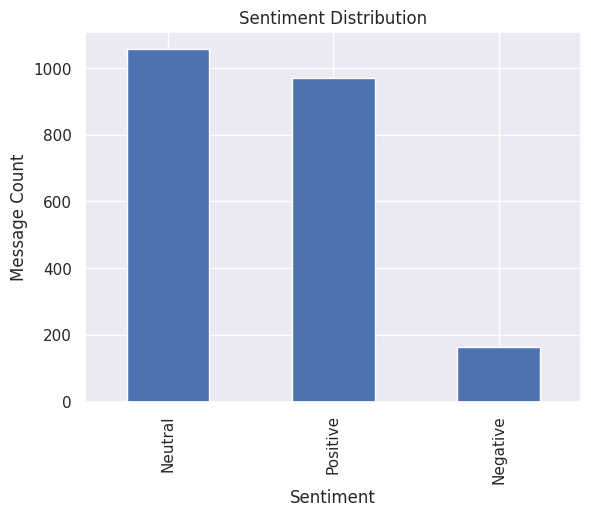

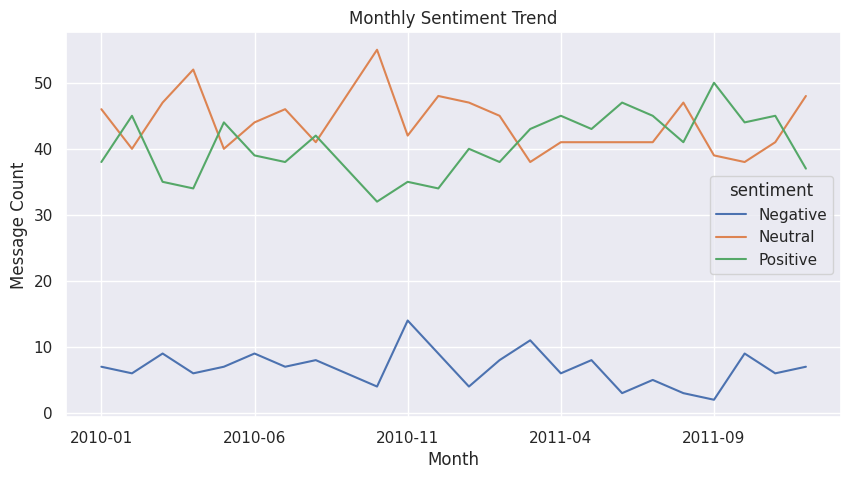


Top 3 Positive Employees (Monthly):
                            from    month  sentiment_score
120      kayne.coulter@enron.com  2010-01                5
168     patti.thompson@enron.com  2010-01                5
24        don.baughman@enron.com  2010-01                4
1    bobette.riner@ipgdirect.com  2010-02                7
73         john.arnold@enron.com  2010-02                7
..                           ...      ...              ...
142      kayne.coulter@enron.com  2011-11                7
22   bobette.riner@ipgdirect.com  2011-11                6
143      kayne.coulter@enron.com  2011-12                5
191     patti.thompson@enron.com  2011-12                5
71           eric.bass@enron.com  2011-12                4

[72 rows x 3 columns]

Top 3 Negative Employees (Monthly):
                            from    month  sentiment_score
192      rhonda.denton@enron.com  2010-01                0
96       johnny.palmer@enron.com  2010-01                1
0    bobette.riner

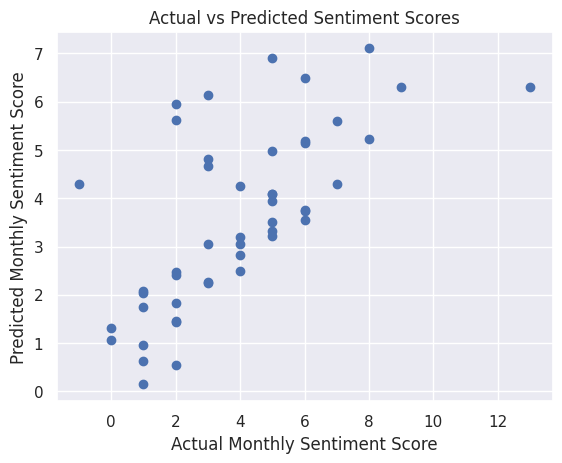

In [1]:
# ============================================================
# EMPLOYEE SENTIMENT ANALYSIS – FULL PIPELINE (TEXTBLOB)
# Dataset: test.csv
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------
# 1. LOAD & CLEAN DATA
# ------------------------------------------------------------

df = pd.read_csv("test.csv")
df.columns = df.columns.str.lower()

# Required columns: from, date, body
df['date'] = pd.to_datetime(df['date'])
df['body'] = df['body'].astype(str)

print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

# ------------------------------------------------------------
# 2. SENTIMENT LABELING (TEXTBLOB)
# ------------------------------------------------------------

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['body'].apply(get_sentiment)

print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# ------------------------------------------------------------
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------

sns.set()

# Sentiment distribution
plt.figure()
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Message Count")
plt.show()

# Monthly trend
df['month'] = df['date'].dt.to_period('M').astype(str)

monthly_sentiment = (
    df.groupby(['month', 'sentiment'])
    .size()
    .unstack(fill_value=0)
)

monthly_sentiment.plot(figsize=(10,5))
plt.title("Monthly Sentiment Trend")
plt.xlabel("Month")
plt.ylabel("Message Count")
plt.show()

# ------------------------------------------------------------
# 4. MONTHLY SENTIMENT SCORING
# ------------------------------------------------------------

sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

monthly_scores = (
    df.groupby(['from', 'month'])['sentiment_score']
    .sum()
    .reset_index()
)

# ------------------------------------------------------------
# 5. EMPLOYEE RANKING
# ------------------------------------------------------------

top_positive = (
    monthly_scores
    .sort_values(['month', 'sentiment_score', 'from'],
                 ascending=[True, False, True])
    .groupby('month')
    .head(3)
)

top_negative = (
    monthly_scores
    .sort_values(['month', 'sentiment_score', 'from'],
                 ascending=[True, True, True])
    .groupby('month')
    .head(3)
)

print("\nTop 3 Positive Employees (Monthly):")
print(top_positive)

print("\nTop 3 Negative Employees (Monthly):")
print(top_negative)

# ------------------------------------------------------------
# 6. FLIGHT RISK IDENTIFICATION (ROLLING 30 DAYS)
# ------------------------------------------------------------
# Rule: >=4 negative emails in ANY rolling 30-day window

neg = df[df['sentiment'] == 'Negative'].copy()
neg = neg.sort_values('date')

neg['neg_30d'] = (
    neg.groupby('from')
       .rolling('30D', on='date')
       .count()['sentiment']
       .reset_index(level=0, drop=True)
)

flight_risk_employees = (
    neg.loc[neg['neg_30d'] >= 4, 'from']
    .drop_duplicates()
    .tolist()
)

print("\nFlight Risk Employees (>=4 negative messages in 30 days):")
print(flight_risk_employees)

# ------------------------------------------------------------
# 7. FEATURE ENGINEERING FOR REGRESSION
# ------------------------------------------------------------

df['msg_length'] = df['body'].str.len()
df['word_count'] = df['body'].str.split().str.len()

features = (
    df.groupby(['from', 'month'])
    .agg(
        monthly_score=('sentiment_score', 'sum'),
        message_count=('body', 'count'),
        avg_msg_length=('msg_length', 'mean'),
        avg_word_count=('word_count', 'mean')
    )
    .reset_index()
)

# ------------------------------------------------------------
# 8. LINEAR REGRESSION MODEL
# ------------------------------------------------------------

X = features[['message_count', 'avg_msg_length', 'avg_word_count']]
y = features['monthly_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nLinear Regression Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# ------------------------------------------------------------
# 9. REGRESSION VISUALIZATION
# ------------------------------------------------------------

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Monthly Sentiment Score")
plt.ylabel("Predicted Monthly Sentiment Score")
plt.title("Actual vs Predicted Sentiment Scores")
plt.show()
